In [5]:
import matplotlib.pyplot as plt
import pandas as pd  
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import numpy as np
import missingno as msno
from sklearn.decomposition import PCA

df = pd.read_csv("Data Set Diabetes.csv", delimiter=";")
cols =['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction', 'Age']



In [12]:
print("Informasi DataFrame:")
print(df.info())  

print("\nStatistik Deskriptif:")
print(df.describe())  

print("\nJumlah Missing Values per Kolom:")
print(df.isnull().sum()) 


Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Statistik Deskriptif:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.

In [13]:
print(f"Jumlah zeros pada kolom {cols}:")
for col in cols:
    zero_count = (df[col] == 0).sum()
    print(f"- {col}: {zero_count} zeros ({(zero_count/len(df)*100):.2f}%)")


Jumlah zeros pada kolom ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']:
- Pregnancies: 111 zeros (14.45%)
- Glucose: 5 zeros (0.65%)
- BloodPressure: 35 zeros (4.56%)
- SkinThickness: 227 zeros (29.56%)
- Insulin: 374 zeros (48.70%)
- BMI: 11 zeros (1.43%)
- DiabetesPedigreeFunction: 0 zeros (0.00%)
- Age: 0 zeros (0.00%)


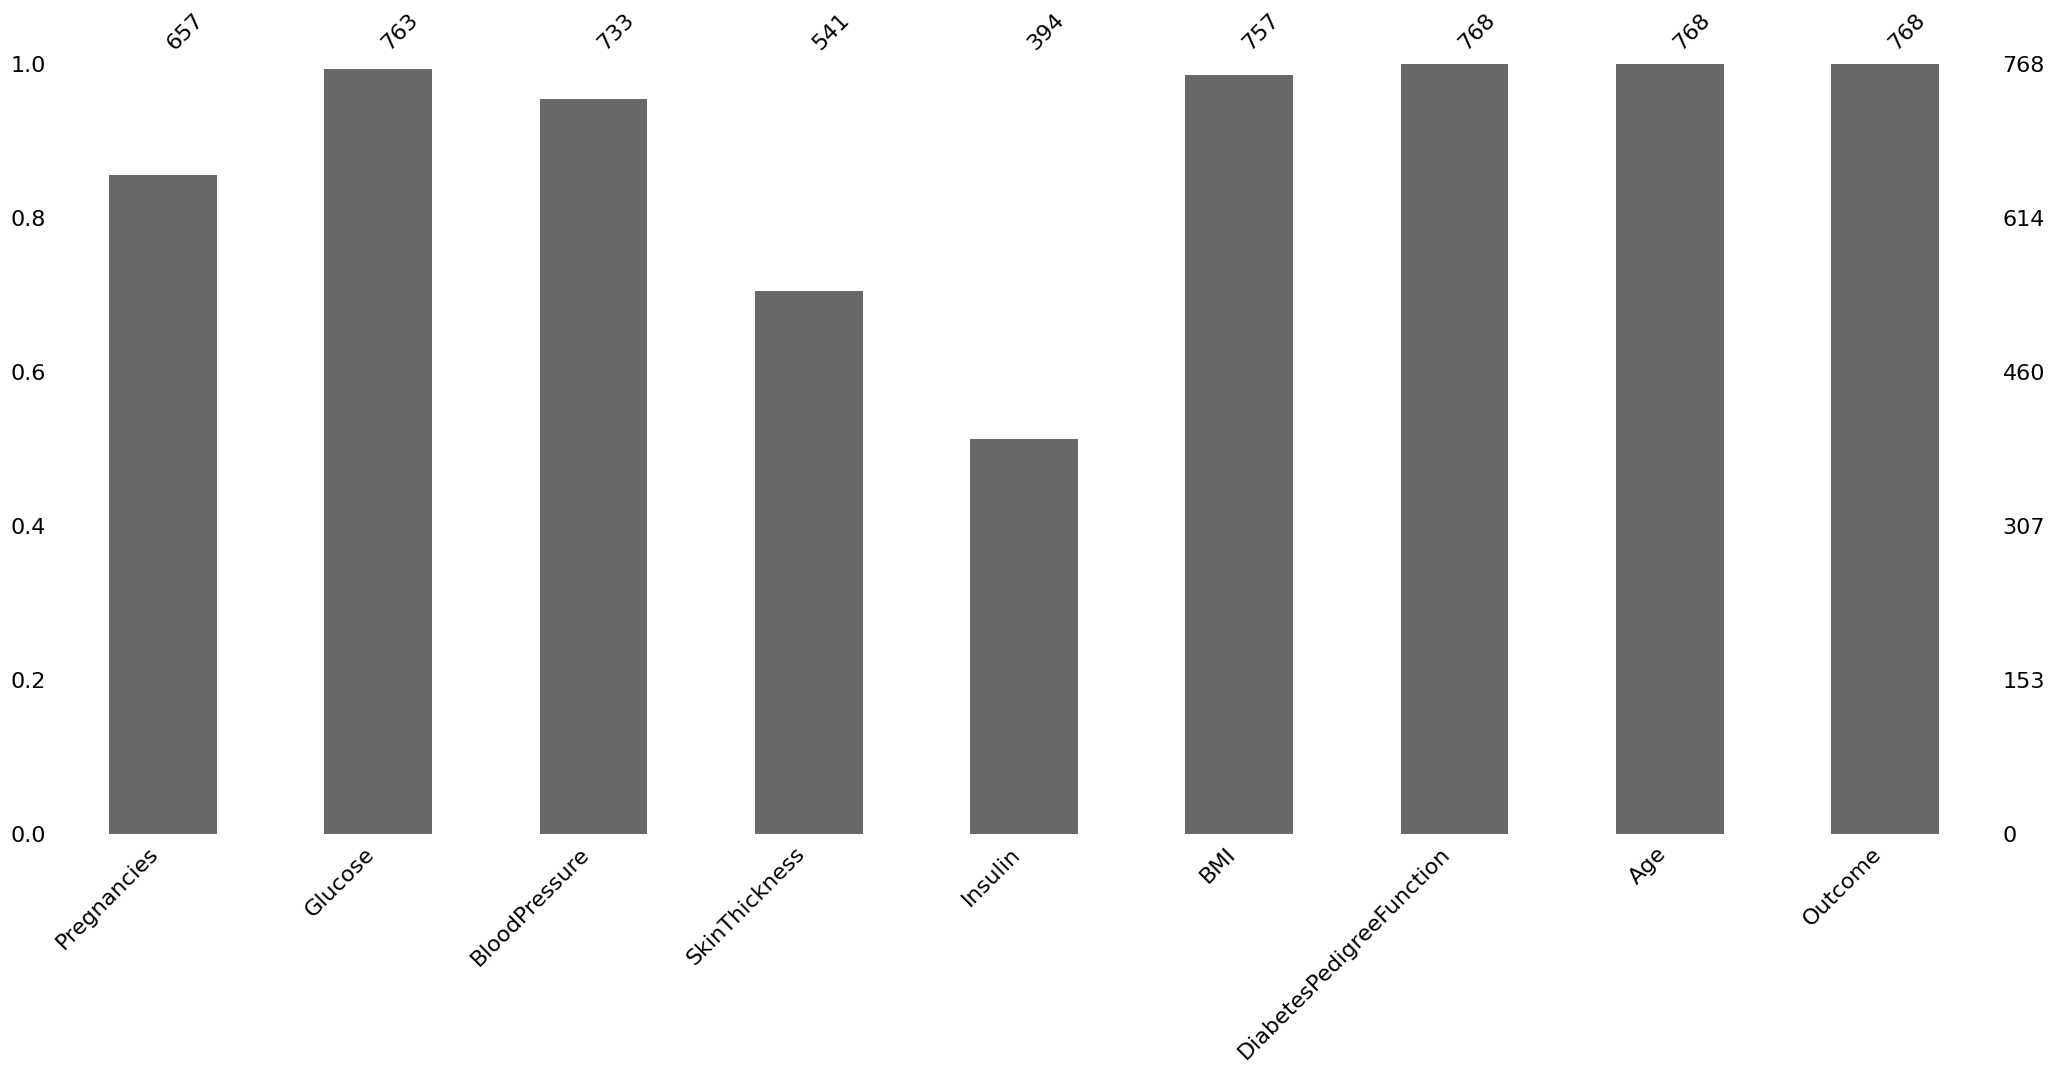

In [14]:
df_temp = df.copy()
for col in cols:
    df_temp[col] = df_temp[col].replace(0, np.nan)

import missingno as msno
msno.bar(df_temp)
plt.show()


In [15]:
for col in cols:
    if df_temp[col].isnull().sum() > 0:
        median = df_temp[col].median()
        df_temp[col] = df_temp[col].fillna(median)

print("Jumlah missing setelah imputasi:")
print(df_temp.isnull().sum()) 


Jumlah missing setelah imputasi:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


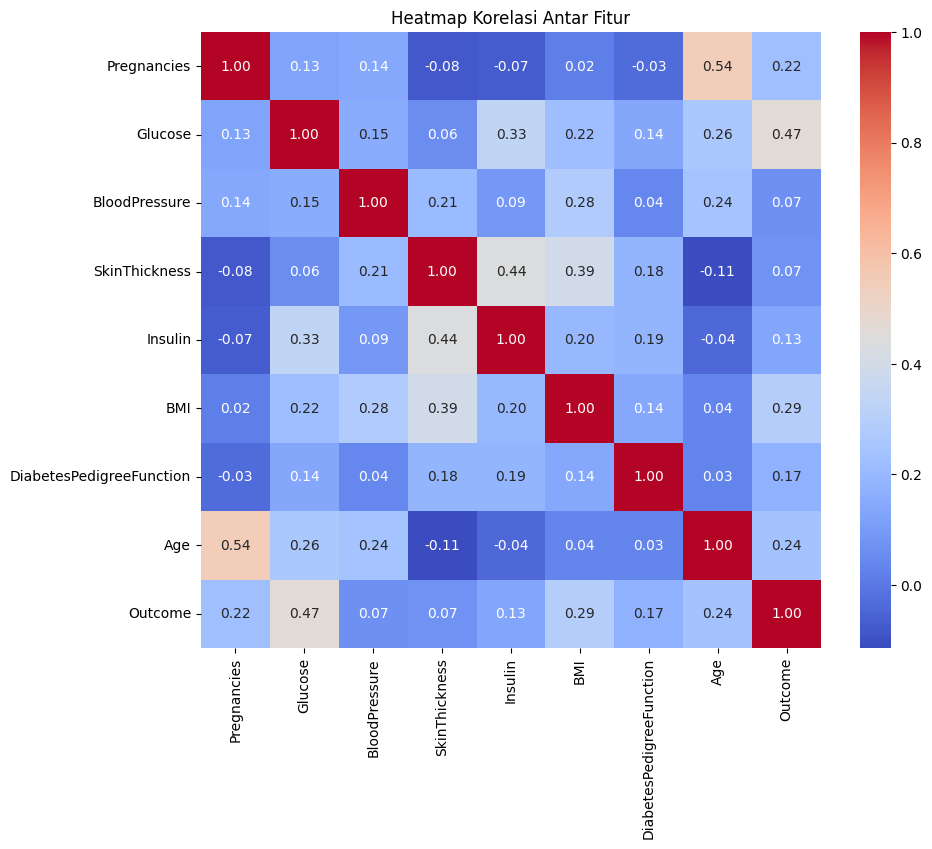

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()


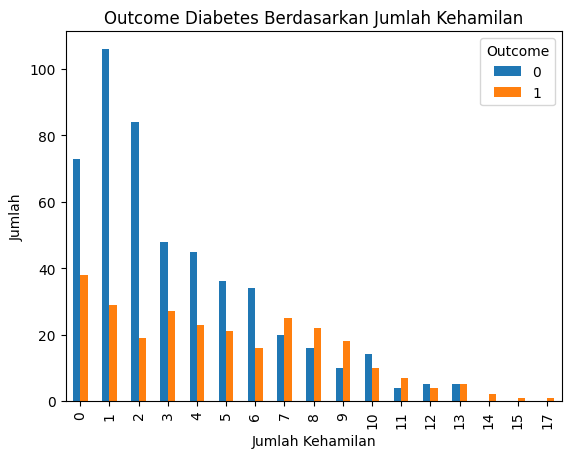

In [17]:
df.groupby("Pregnancies")["Outcome"].value_counts().unstack().plot(kind="bar", stacked=False)
plt.title("Outcome Diabetes Berdasarkan Jumlah Kehamilan")
plt.xlabel("Jumlah Kehamilan")
plt.ylabel("Jumlah")
plt.show()


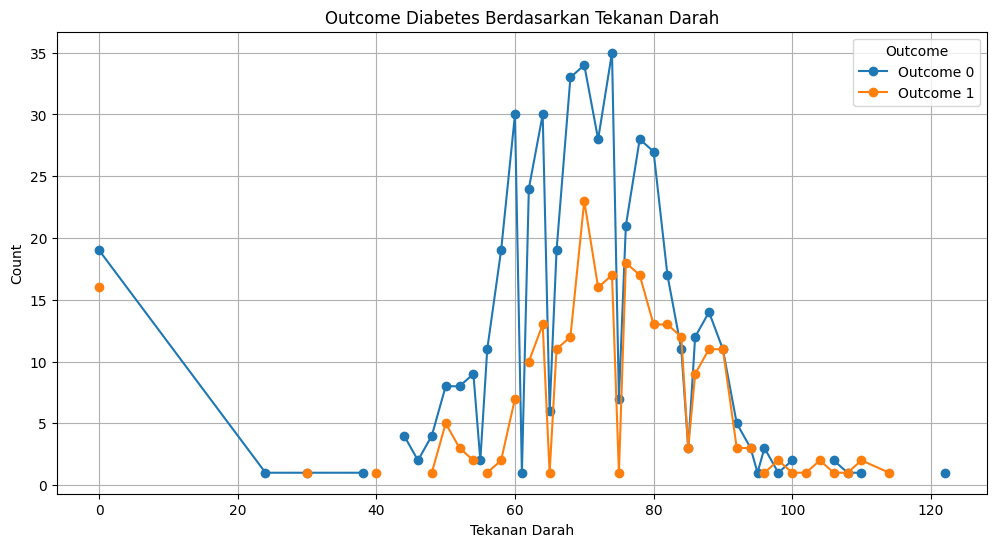

In [18]:
grouped = df.groupby("BloodPressure")["Outcome"].value_counts().unstack()
plt.figure(figsize=(12, 6))
for outcome in grouped.columns:
    plt.plot(grouped.index, grouped[outcome], marker='o', label=f'Outcome {outcome}')

plt.title("Outcome Diabetes Berdasarkan Tekanan Darah")
plt.xlabel("Tekanan Darah")
plt.ylabel("Count")
plt.legend(title='Outcome')
plt.grid(True)
plt.show()


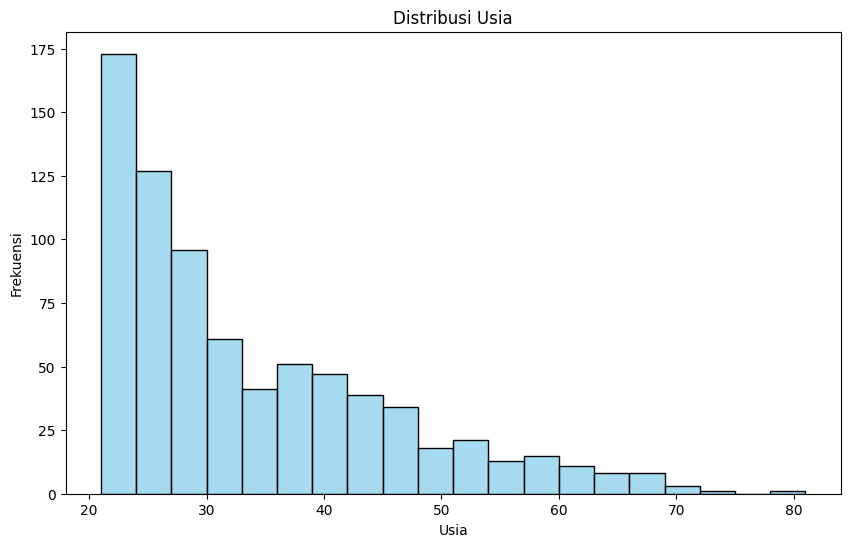

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Usia')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.show()


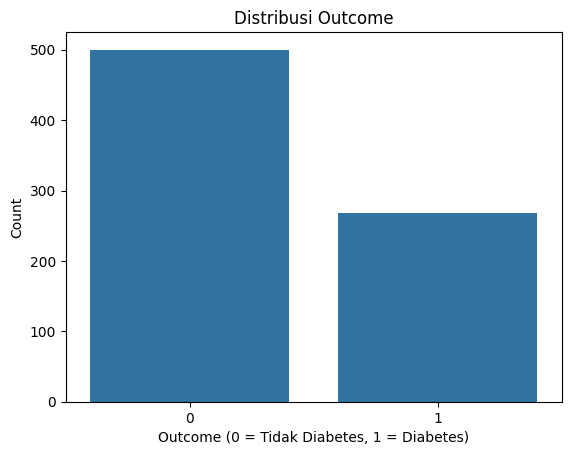

In [20]:
sns.countplot(x='Outcome', data=df)
plt.title('Distribusi Outcome')
plt.xlabel('Outcome (0 = Tidak Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.show()


Jumlah missing setelah imputasi:
Pregnancies                    0
Glucose                        0
BloodPressure                  0
SkinThickness                  0
Insulin                        0
BMI                            0
DiabetesPedigreeFunction       0
Age                            0
Outcome                        0
Glucose_BloodPressure_Ratio    0
dtype: int64

Bentuk sebelum dan sesudah pembersihan:
Before : (768, 9)
After : (768, 10)


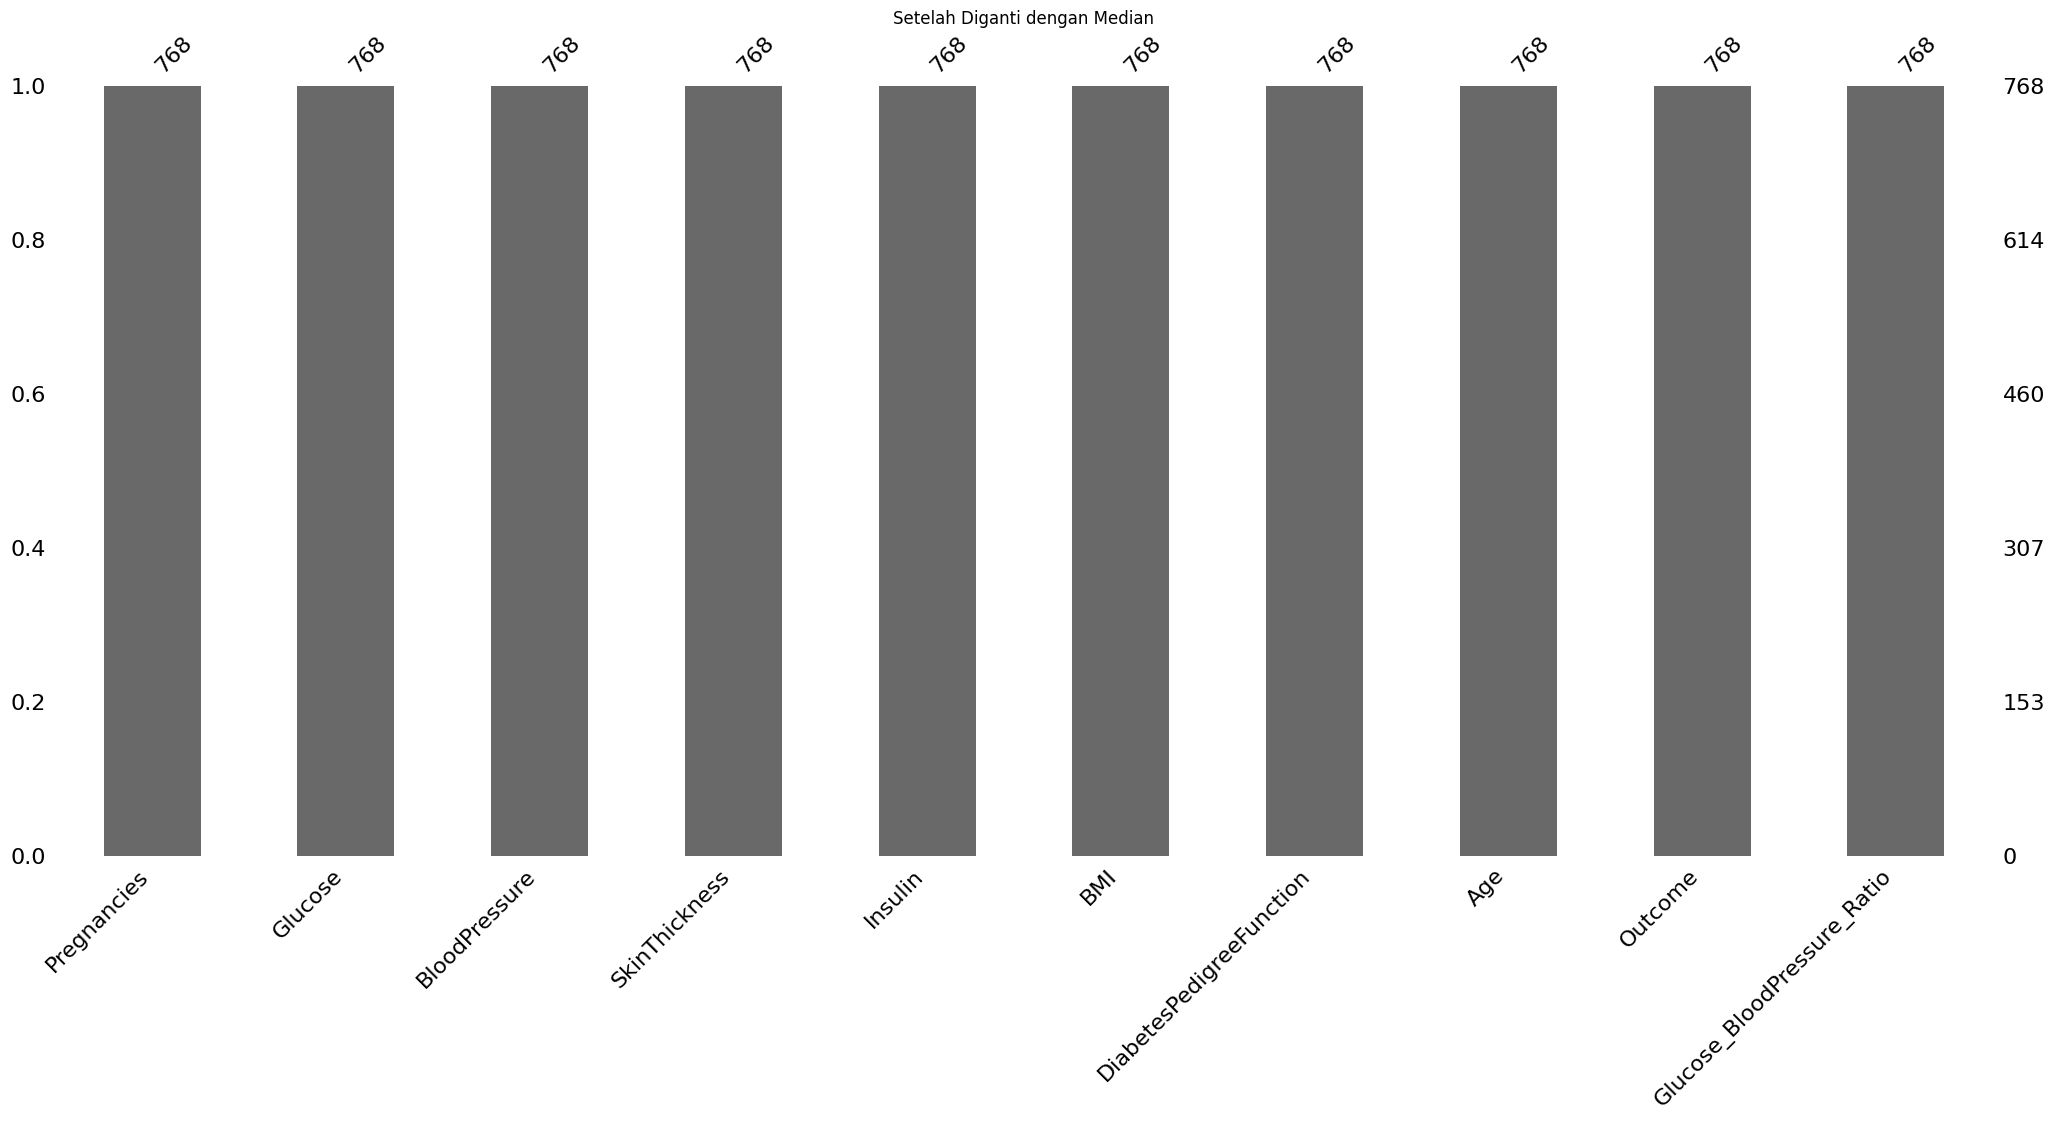

In [22]:
# Salin dan bersih data
df_clean = df.copy()

# Mengganti zeros (kecuali pada 'Pregnancies' dan 'Age') menjadi NaN
for col in cols:
    if col not in ['Pregnancies', 'Age']:
        df_clean[col] = df_clean[col].replace(0, np.nan)

# Mengisi NaN dengan Median
for col in cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)  

# Membuat Fitur Baru
df_clean['Glucose_BloodPressure_Ratio'] = df_clean['Glucose'] / df_clean ['BloodPressure']

print("Jumlah missing setelah imputasi:")
print(df_clean.isnull().sum())  

print("\nBentuk sebelum dan sesudah pembersihan:")
print("Before :", df.shape)
print("After :", df_clean.shape)

# Visualisasi missing
msno.bar(df_clean)
plt.title("Setelah Diganti dengan Median")
plt.show()

In [23]:
# Hapus kolom yang tidak digunakan
drop_cols = ['SkinThickness', 'DiabetesPedigreeFunction']
df_clean = df_clean.drop(columns=drop_cols)


In [24]:
# Fitur yang digunakan
cols_selected = ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'Age', 'Glucose_BloodPressure_Ratio']

# Transformasi
features = df_clean[cols_selected]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

df_scaled = pd.DataFrame(scaled_data, columns=cols_selected)
df_scaled['Outcome'] = df_clean['Outcome'].values


In [25]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled.drop(columns=['Outcome']))
    inertia.append(kmeans.inertia_)

kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
print(f"Jumlah Optimal K (menurut Elbow Method) : {kl.elbow}")


Jumlah Optimal K (menurut Elbow Method) : 5


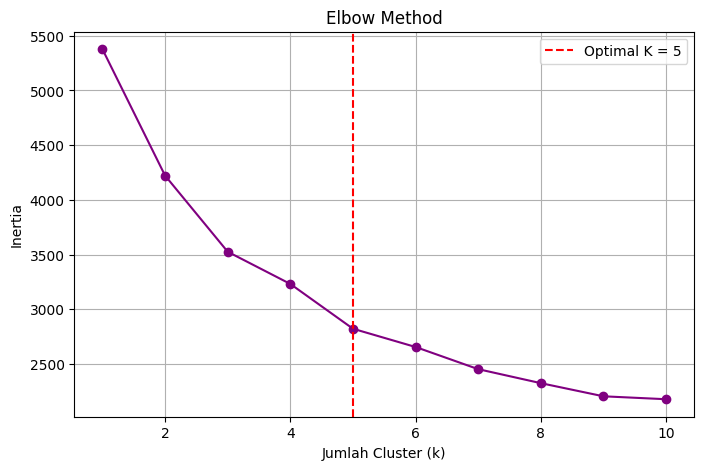

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='purple')
plt.axvline(x=kl.elbow, color='red', linestyle='--', label=f'Optimal K = {kl.elbow}')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
pca = PCA(n_components=2)
x_features = df_scaled.drop(columns=['Outcome'])
principal_comp = pca.fit_transform(x_features)

df_pca = pd.DataFrame(data=principal_comp, columns=['PC1', 'PC2'])


In [28]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(x_features)

df_pca['Cluster'] = clusters


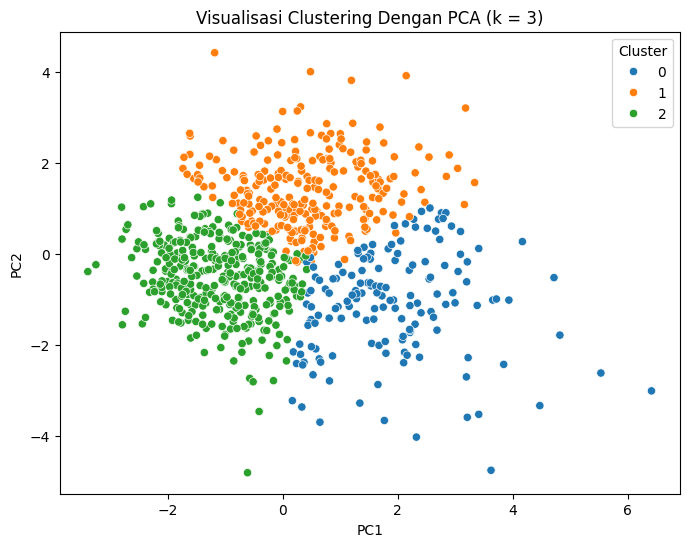

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='tab10', data=df_pca)
plt.title('Visualisasi Clustering Dengan PCA (k = 3)')
plt.show()


In [30]:
score = silhouette_score(x_features, clusters)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.2244
